In [24]:
# All imports here
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding
from datetime import datetime
import matplotlib.pyplot as plt

In [25]:
BATCH_SIZE = 16
SEQUENCE_LENGTH = 64

In [26]:
# Path to the input data directory
input_data_dir = "/content/drive/MyDrive/NeuralNets/Project/data/"
char_to_idx_fname = "char_to_index.json"

train_data_path = input_data_dir + "train.npy"
label_data_path = input_data_dir + "labels.npy"
trained_model_weight_path = input_data_dir + "trained_bidirectional_lstm.h5"

In [27]:
char_to_index = json.load(open(input_data_dir + char_to_idx_fname))
index_to_char = { i: ch for ch, i in char_to_index.items() }
VOCAB_SIZE = len(char_to_index)
print("Char to index mapping size: ", VOCAB_SIZE)

Char to index mapping size:  93


In [28]:
# Get the data and labels from files
data = np.load(train_data_path)
labels = np.load(label_data_path)
print(data.shape, labels.shape)

(441, 16, 64) (441, 16, 64, 93)


In [29]:
# Build LSTM models
def build_bidirectional_lstm(batch_size, seq_length, vocab_size):
  bidirectional_lstm = Sequential()
  bidirectional_lstm.add(Embedding(vocab_size, 512, batch_input_shape=(batch_size, seq_length)))
  bidirectional_lstm.add(Bidirectional(LSTM(32, return_sequences=True, stateful=True)))
  bidirectional_lstm.add(Dropout(0.2))
  bidirectional_lstm.add(Bidirectional(LSTM(32, return_sequences=True, stateful=True)))
  bidirectional_lstm.add(Dropout(0.2))
  bidirectional_lstm.add(Bidirectional(LSTM(32, return_sequences=True, stateful=True)))
  bidirectional_lstm.add(Dropout(0.2))
  bidirectional_lstm.add(TimeDistributed(Dense(vocab_size))) 
  bidirectional_lstm.add(Activation("softmax"))

  bidirectional_lstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  bidirectional_lstm.summary()
  return bidirectional_lstm

def build_bidirectional_lstm_predictor(vocab_size):
  bidirectional_lstm = Sequential()
  bidirectional_lstm.add(Embedding(vocab_size, 512, batch_input_shape=(1, 1)))
  bidirectional_lstm.add(Bidirectional(LSTM(32, return_sequences=True, stateful=True)))
  bidirectional_lstm.add(Dropout(0.2))
  bidirectional_lstm.add(Bidirectional(LSTM(32, return_sequences=True, stateful=True)))
  bidirectional_lstm.add(Dropout(0.2))
  bidirectional_lstm.add(Bidirectional(LSTM(32, return_sequences=False, stateful=True)))
  bidirectional_lstm.add(Dropout(0.2))
  bidirectional_lstm.add(Dense(vocab_size, activation="softmax"))
  return bidirectional_lstm

In [30]:
def plot_util(values, xlabel, ylabel, title):
  plt.plot(range(len(values)), values)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

In [31]:
bidirectional_lstm_model = build_bidirectional_lstm(BATCH_SIZE, SEQUENCE_LENGTH, VOCAB_SIZE)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (16, 64, 512)             47616     
                                                                 
 bidirectional_6 (Bidirectio  (16, 64, 64)             139520    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (16, 64, 64)              0         
                                                                 
 bidirectional_7 (Bidirectio  (16, 64, 64)             24832     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (16, 64, 64)              0         
                                                                 
 bidirectional_8 (Bidirectio  (16, 64, 64)            

In [32]:
# Helper for Train the model
def train_model(epochs, data, labels, model):
  avg_loss, avg_accuracy = [], []
  for epoch in range(epochs):

    losses, metrics = [], []
    start = datetime.now()

    # Train on all the batches for a single epoch
    for idx, X in enumerate(data):
      cur_loss, cur_acc = model.train_on_batch(X, labels[idx])
      losses.append(cur_loss)
      metrics.append(cur_acc)
    
    # Average loss and accuracy per epoch
    print(f"Epoch {epoch} : Average loss {np.mean(losses)}, Average accuracy {np.mean(metrics)}")
    avg_loss.append(np.mean(losses))
    avg_accuracy.append(np.mean(metrics))

    if (epoch+1)%10==0:
      print(f"Completed epochs : {epoch+1}")
    
  total_time_taken = datetime.now() - start
  
  return avg_loss, avg_accuracy, total_time_taken

In [33]:
losses, metrics, total_time_taken = train_model(100, data, labels, bidirectional_lstm_model)

Epoch 0 : Average loss 2.2980252162399206, Average accuracy 0.4011501736111111
Epoch 1 : Average loss 0.5615155496159379, Average accuracy 0.8943961699263039
Epoch 2 : Average loss 0.25086167444582697, Average accuracy 0.9639779088718821
Epoch 3 : Average loss 0.18770509559551335, Average accuracy 0.9750212585034014
Epoch 4 : Average loss 0.1582380262733587, Average accuracy 0.978657348356009
Epoch 5 : Average loss 0.1401874759570271, Average accuracy 0.9807898419784581
Epoch 6 : Average loss 0.12700831744811433, Average accuracy 0.982304510345805
Epoch 7 : Average loss 0.11740961037322778, Average accuracy 0.9830596301020408
Epoch 8 : Average loss 0.10838111162253247, Average accuracy 0.9839431866496599
Epoch 9 : Average loss 0.10166637879920924, Average accuracy 0.9846075148809523
Completed epochs : 10
Epoch 10 : Average loss 0.09653218026334195, Average accuracy 0.9849308212868481
Epoch 11 : Average loss 0.091626671225238, Average accuracy 0.9854312818877551
Epoch 12 : Average loss 

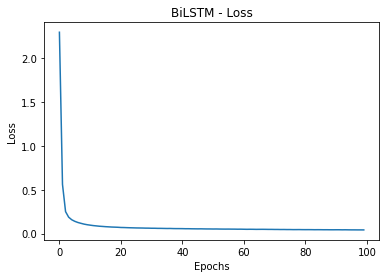

In [34]:
plot_util(losses, 'Epochs', 'Loss', 'BiLSTM - Loss')

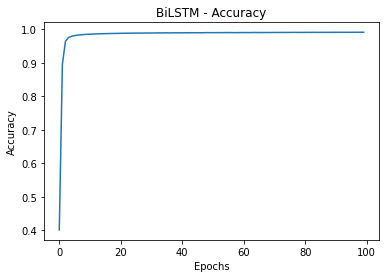

In [47]:
plot_util(metrics, 'Epochs', 'Accuracy', 'BiLSTM - Accuracy')

In [36]:
print(f'The total time taken to train the Bidrectional LSTM model is {total_time_taken}')

The total time taken to train the Bidrectional LSTM model is 0:00:09.283031


In [37]:
# save the model weights
bidirectional_lstm_model.save(trained_model_weight_path)

In [38]:
# Generate music
def generate_music(length, model):

  sampled = []

  for i in range(length):
      batch = np.zeros((1, 1))

      if len(sampled)>0:
        batch[0, 0] = sampled[-1]
      else:
        batch[0, 0] = np.random.randint(VOCAB_SIZE)
      result = model.predict_on_batch(batch).ravel()
      sample = np.random.choice(range(VOCAB_SIZE), p=result)
      sampled.append(sample)

  return ''.join(index_to_char[c] for c in sampled)

In [39]:
# Build the predictor
predictor = build_bidirectional_lstm_predictor(VOCAB_SIZE)
predictor.load_weights(trained_model_weight_path)

In [40]:
output1 = generate_music(1024, predictor)

In [41]:
print(output1)

m)s)s)s)s)s)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)b)

In [42]:
output2 = generate_music(1024, predictor)

In [43]:
print(output2)

b3b3b3b3b3b3b3b3b3b3b3b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|b|bgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbgbg

In [44]:
output3 = generate_music(1024, predictor)

In [45]:
print(output3)

bnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnbnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsnsn